# Solution 3

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on:

- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the corporate  bonds symbology file `corp_symbology`,
- the market data file `market_prices_eod` and
- the corporate bonds call schedule file `call_schedules`.


# Problem 1: More details on callable bonds: "workout-date" and "yield-to-worst" calculations

In [49]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

## a. Load and explore the call schedules dataframe

Load the `call_schedules` Excel file into a dataframe. It contains call schedules for fixed-rate, callable corporate bonds.

For each bond in the dataframe, compute the total number of outstanding calls.

In [50]:
call_schedules_df = pd.read_excel('../data/call_schedules.xlsx')
print(call_schedules_df.head())

call_schedules_count_df = call_schedules_df[['figi', 'call_date']].groupby(['figi']).count()
call_schedules_count_df.columns = ['num_call_dates']
print(call_schedules_count_df.describe())



           isin          figi  call_date  call_price
0  US254687CZ75  BBG00QNKJ092 2024-06-15         100
1  US254687DD54  BBG00QNKPCL5 2025-07-15         100
2  US254687DK97  BBG00QNKGJP6 2026-08-15         100
3  US254687EX00  BBG00QNKKP22 2045-04-15         100
4  US254687FB70  BBG00QNKKP68 2046-05-15         100
       num_call_dates
count          100.00
mean             1.15
std              1.50
min              1.00
25%              1.00
50%              1.00
75%              1.00
max             16.00


## b. Load symbology dataframe and extend it with the fixed-rate callable corporate bond details from 1a.

Load the `corp_symbology` Excel file into a dataframe and keep only the fixed-rate callable bonds from 1a.

Extend the dataframe with the column computed in 1a:

| num_call_dates |
|----------|

In [51]:
corp_symbology_df = pd.read_excel('../data/corp_symbology.xlsx')
corp_symbology_df = corp_symbology_df[corp_symbology_df['cpn_type'] == 'FIXED']

# combined_df
combined_df = corp_symbology_df.merge(call_schedules_count_df, how='right', on=['figi'])
print(combined_df.head())


  ticker class          figi          isin        trace und_bench_isin   
0     VZ  Corp  BBG003LZSS91  US92343VBG86    VZ3926361   US912810TQ13  \
1   ORCL  Corp  BBG006R54K79  US68389XAU90  ORCL4141352   US91282CGU99   
2   ORCL  Corp  BBG006R54KG9  US68389XAV73  ORCL4141354   US91282CGM73   
3   ORCL  Corp  BBG006R54KN1  US68389XAW56  ORCL4141355   US912810TQ13   
4     VZ  Corp  BBG007DM0XF2  US92343VCR33    VZ4176696   US91282CGU99   

              security                    name    type  coupon  ...   
0     VZ 3.85 11/01/42  VERIZON COMMUNICATIONS  GLOBAL    3.85  ...  \
1    ORCL 3.4 07/08/24             ORACLE CORP  GLOBAL    3.40  ...   
2    ORCL 4.3 07/08/34             ORACLE CORP  GLOBAL    4.30  ...   
3  ORCL 4 1/2 07/08/44             ORACLE CORP  GLOBAL    4.50  ...   
4    VZ 3 1/2 11/01/24  VERIZON COMMUNICATIONS  GLOBAL    3.50  ...   

  days_settle start_date  cpn_first  acc_first   maturity   mty_typ   
0           2 2012-11-07 2013-05-01 2012-11-07 2042-11-01

## c. Add a function to compute "workout date" and "yield-to-worst" for a fixed-rate callable bond

Quick recap: given the current market price, the issuer is expected to call a callable bond on the call date corresponding to lowest bond yield "to call date" (which is the best possible scenario from the point of view of the issuer exercising the call option). The lowest yield for a call date is called the "yield-to-worst" and the corresponding call date (on which the issuer is expected to call the bond) is called the "workout date". Keep in mind that the "workout date" could be at the bond maturity date, in which case "yield-to-worst" = "yield-to-maturity".

To do: For a callable bond, with known symbology (reference data) and call schedules dataframes, create a function that takes the clean market price as an input and returns "workout date" and "yield-to-worst".

Internally, for each call date, create a separate "call scenario bond" object using the function create_bond_from_symbology() from Homework 2, and then compute the corresponding "call scenario yield" for the "call scenario bond" (using the bond clean market price).


In [52]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")


def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    maturity = get_ql_date(details['maturity'])
    
    # Create acc_first from details['acc_first']
    acc_first = get_ql_date(details['acc_first'])
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    period = ql.Period(2)
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule


def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporates use ql.Thirty360(ql.Thirty360.USA)
    if details['dcc'] == '30/360':
        day_count = ql.Thirty360(ql.Thirty360.USA)
    elif details['dcc'] == 'ACT/ACT':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    else:
        raise ValueError(f"unsupported day count, {type(details['dcc'])}, {details['dcc']}")
    
    # Create day_count from details['start_date']    
    issue_date = get_ql_date(details['start_date'])
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create days_settle from details['coupon']
    coupon = float(details['coupon'])/100.

    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond

In [86]:
def calc_yield_to_worst(
            details: dict,
            pc_schedule: pd.DataFrame,
            bond_clean_price: float,
            calc_date: ql.Date):
    '''Computes yield-to-worst and workout date for fixed rate callable bonds.
    '''    
    
    maturity_date =  details['maturity']
    yield_to_maturity = details['yield_to_maturity']

    workout_date = maturity_date
    yield_to_worst = yield_to_maturity        
    
    # keep schedules for used bond only
    used_pc_schedule = pc_schedule[pc_schedule['figi'] == details['figi']]
    
    for _, row in used_pc_schedule.iterrows():
        call_date = get_ql_date(row['call_date'])
        if call_date > calc_date:
            
            # Create a call scenario details df
            call_scenario_details = details.copy()
            call_scenario_details['maturity'] = row['call_date']
            call_scenario_bond = create_bond_from_symbology(call_scenario_details)
            
            # scenario_yield
            call_scenario_yield = call_scenario_bond.bondYield(bond_clean_price, call_scenario_bond.dayCounter(), ql.Compounded, ql.Semiannual) * 100
                                            
            # Update yield_to_worst and workout_date if needed
            if call_scenario_yield < yield_to_worst:
                print('Found new workout date:', details['figi'], workout_date, call_date.to_date(), yield_to_worst, call_scenario_yield)
                
                yield_to_worst = call_scenario_yield
                workout_date = call_date.to_date()                                                            
                
    return workout_date, yield_to_worst


## d. Compute "workout dates" and "yields-to-worst" for all fixed-rate callable bonds

Load the `market_prices_eod` Excel file into a dataframe, which contains marktet quotes as of 2023-04-14.

For each fixed-rate callable bond in the symbology dataframe from 1b (using calc_date = '2023-04-14' and clean market prices):
- 1. Compute the yield to maturity 

- 2. Use the function from 1c to compute "workout date" and "yield-to-worst".

Extend the symbology dataframe with the following columns:


| clean_price |  yield_to_maturity | workout_date | yield_to_worst |
|----------|-------------|-------|-------------|



In [54]:
# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

In [88]:
# market_prices_df
market_prices_df = pd.read_excel('../data/market_prices_eod.xlsx')
# market_prices_df.set_index('figi',inplace=True)

# combined_df
combined_df = corp_symbology_df.merge(market_prices_df, how='inner', on=['class', 'ticker', 'isin', 'figi'])
# combined_df.set_index('figi',inplace=True)

# add yield_to_maturity
combined_df['clean_price'] = (combined_df['bid'] + combined_df['ask'])/2
combined_df['yield_to_maturity'] = (combined_df['bid_yield'] + combined_df['ask_yield'])/2

# add dummy workout_date & yield_to_worst columns, to be populated later
combined_df['workout_date'] = combined_df['date']
combined_df['yield_to_worst'] = 0

# print(combined_df.head())


In [94]:
for row_index, row in combined_df.iterrows():
        
    details = row.to_dict()
        
    bond_clean_price = details['clean_price']
    
    workout_date, yield_to_worst = calc_yield_to_worst(details, call_schedules_df, bond_clean_price, calc_date)
    
    combined_df.loc[row_index, 'workout_date'] = workout_date
    combined_df.loc[row_index, 'yield_to_worst'] = yield_to_worst
          
# Show bonds with workout_date != maturity !!!
print('Bonds with workout_date < maturity (early call):')
print(combined_df[combined_df['maturity'] != combined_df['workout_date']][['isin', 'figi', 'ticker', 'security', 'clean_price', 'maturity', 'workout_date', 'yield_to_maturity', 'yield_to_worst']])

Found new workout date: BBG01BFF10D8 2029-11-09 00:00:00 2029-09-09 4.9745 4.9670324325561515
Found new workout date: BBG01BFF10W7 2032-11-09 00:00:00 2032-08-09 5.2085 5.203837394714355
Found new workout date: BBG01BFF1128 2052-11-09 00:00:00 2052-05-09 6.042 6.041565465927123
Bonds with workout_date < maturity (early call):
             isin          figi ticker             security  clean_price   
128  US68389XCH61  BBG01BFF10D8   ORCL   ORCL 6.15 11/09/29     106.3700  \
129  US68389XCJ28  BBG01BFF10W7   ORCL  ORCL 6 1/4 11/09/32     107.6065   
130  US68389XCK90  BBG01BFF1128   ORCL    ORCL 6.9 11/09/52     111.6810   

      maturity workout_date  yield_to_maturity  yield_to_worst  
128 2029-11-09   2029-09-09             4.9745        4.967032  
129 2032-11-09   2032-08-09             5.2085        5.203837  
130 2052-11-09   2052-05-09             6.0420        6.041565  


# Problem 2: Perpetual bonds
## a. Price a fixed rate perpetual bond
We are interested in a fixed rate perpetual bond (infinite maturity) on a face notional of $100 and semi-annual coupon c.

Assuming that the bond has a (continuously componded) yield of y, what is the fair value price of the bond?

For simplicity, you can assume T+0 settlement and zero accrued.

We start with the formula for pricing a risky fixed rate bond on a face of 100%, derived in Lecture 1, formulas [4] and [5].

\begin{align}
B_{0}^{T}=B(0,c,T,y)=\sum_{k=1}^{2T}\frac{c}{2}\cdot e^{-k\cdot\frac{y}{2}}+e^{-T\cdot y}
\end{align}

\begin{align}
=1+\frac{\frac{c}{2}-\left(e^{\frac{y}{2}}-1\right)}{e^{\frac{y}{2}}-1}\cdot\left(1-e^{-T\cdot y}\right)=1+\frac{c-y_{sa}}{y_{sa}}\cdot\left[1-\left(1+\frac{y_{sa}}{2}\right)^{-2T}\right]
\end{align}


In the case of the fixed rate perpetual bond, the cashflows extend to "infinity", and the formula simplifies to

\begin{align}
B_{0}^{\infty}=B(0,c,\infty,y)=\sum_{k=1}^{\infty}\frac{c}{2}\cdot e^{-k\cdot\frac{y}{2}} =  \frac{c}{2 \cdot \left(e^{\frac{y}{2}}-1 \right)}=\frac{c}{y_{sa}},
\end{align}

where $y_{sa}$ is the semi-annual bond yield. 

To obtain the fair price on a face of $100, one has to multiply the formula above by 100:
\begin{align}
B_{0}^{\infty}(100) =  \frac{100 \cdot c}{2 \cdot \left(e^{\frac{y}{2}}-1 \right)} = 100 \cdot \frac{c}{y_{sa}},
\end{align}


## b. Perpetual bonds priced "at par"
For which yield y does the bond trade "at par", i.e. fair value price = $100?


\begin{align}
B_{0}^{\infty}(100)=100 \iff y=2\cdot \ln \left( 1 + \frac{c}{2} \right) \iff y_{sa} = c.
\end{align}


Hence, the perpetual bond trades "at par" if the smi-annual yield $y_{sa}$ matches the semi-annual coupon c (same result as for "regular" fixed rate bonds).

## c. Duration and DV01 for a fixed rate perpetual bond
Compute Duration and DV01 of the perpetual bond.

In [57]:
# import library
import sympy as sp

# define symbolic variable
y = sp.symbols('y')

# define symbolic equations
perpetual_bond_price = 1 / (sp.exp(y/2) - 1) / 2
print('perpetual_bond_price (unit coupon):', perpetual_bond_price)

# find first and second order derivatives
first_order_derivative = perpetual_bond_price.diff(y)
print('first_order_derivative:', first_order_derivative)

perpetual_bond_duration =  sp.simplify(- first_order_derivative / perpetual_bond_price)
print('perpetual_bond_duration:', perpetual_bond_duration)

second_order_derivative = sp.simplify(first_order_derivative.diff(y))
print('second_order_derivative:', second_order_derivative)

perpetual_bond_convexity =  sp.simplify(second_order_derivative / perpetual_bond_price)
print('perpetual_bond_convexity:', perpetual_bond_convexity)


perpetual_bond_price (unit coupon): 1/(2*(exp(y/2) - 1))
first_order_derivative: -exp(y/2)/(4*(exp(y/2) - 1)**2)
perpetual_bond_duration: exp(y/2)/(2*exp(y/2) - 2)
second_order_derivative: -((exp(y/2) - 1)*exp(y/2) - 2*exp(y))/(8*(exp(y/2) - 1)**3)
perpetual_bond_convexity: (1 + exp(-y/2))*exp(y)/(4*(-2*exp(y/2) + exp(y) + 1))


\begin{align}
PV01 = -\frac{\partial B}{\partial y} = -\frac{\partial}{\partial y}\left[\frac{c}{2 \cdot \left( e^{\frac{y}{2}}-1 \right) }\right]=\frac{c \cdot e^{\frac{y}{2}}}{4 \cdot \left( e^{\frac{y}{2}} - 1 \right)^2} = B \cdot \frac{e^{\frac{y}{2}}}{2 \cdot \left( e^{\frac{y}{2}} - 1 \right)}
\end{align}


Hence, duration $D$ of a fixed rate perpetual bond is given by

\begin{align}
D = -\frac{1}{B} \cdot \frac{\partial B}{\partial y} = \frac{e^{\frac{y}{2}}}{2 \cdot \left( e^{\frac{y}{2}} - 1 \right)} = \frac{1 + \frac{y_{sa}}{2} }{y_{sa}}.
\end{align}


## d. Convexity of a fixed rate perpetual bond
Compute the convexity of the perpetual bond.

\begin{align}
\frac{\partial^{2} B}{\partial y^{2}} = \frac{\partial^{2}}{\partial y^{2}}\left[\frac{\frac{c}{2}}{e^{\frac{y}{2}}-1}\right] = \frac{\partial}{\partial y}\left[\frac{c \cdot e^{\frac{y}{2}}}{4 \cdot \left( e^{\frac{y}{2}} - 1 \right)^2} \right] = \frac{c \cdot e^{\frac{y}{2}} \cdot \left(e^{\frac{y}{2}} + 1 \right)}{8 \cdot \left( e^{\frac{y}{2}} - 1 \right)^3}  = B \cdot \frac{e^{\frac{y}{2}} \cdot \left(e^{\frac{y}{2}} + 1 \right)}{4 \cdot \left( e^{\frac{y}{2}} - 1 \right)^2}
\end{align}


Hence, convexity $\Gamma$ of a fixed rate perpetual bond is given by

\begin{align}
\Gamma = \frac{1}{B} \cdot \frac{\partial^{2} B}{\partial y^{2}} = \frac{e^{\frac{y}{2}} \cdot \left(e^{\frac{y}{2}} + 1 \right)}{4 \cdot \left( e^{\frac{y}{2}} - 1 \right)^2} =  \frac{\left( 1 + \frac{y_{sa}}{2} \right) \cdot \left( 2 + \frac{y_{sa}}{2} \right)}{y_{sa}^2}. 
\end{align}


# Problem 3: US SOFR swap curve calibration as of 2023-04-28
### Follow Section "11. SOFR OIS swap rates and SOFR discount curve calibration + validation" in the QuantLib Intro notebook !!!

## a. Load and explore US SOFR swaps symbology and market data

Load the `sofr_swap_symbology` Excel file into a dataframe. Print all swap tenors available.

Load the `sofr_swaps_market_data_eod` Excel file into a dataframe. Print all dates available.

Plot the historial time series of SOFR rates for the available [1Y, 2Y, 3Y, 5Y, 7Y, 10Y, 20Y, 30Y] tenors.

                ticker   class              bbg                      name   
figi                                                                        
BBG00KFWPJJ9   USOSFR1  Curncy   USOSFR1 Curncy   USD OIS  ANN VS SOFR 1Y  \
BBG00KFWPJX3   USOSFR2  Curncy   USOSFR2 Curncy   USD OIS  ANN VS SOFR 2Y   
BBG00KFWPK15   USOSFR3  Curncy   USOSFR3 Curncy   USD OIS  ANN VS SOFR 3Y   
BBG00KFWPK51   USOSFR5  Curncy   USOSFR5 Curncy   USD OIS  ANN VS SOFR 5Y   
BBG00KFWPK79   USOSFR7  Curncy   USOSFR7 Curncy   USD OIS  ANN VS SOFR 7Y   
BBG00KFWPKB4  USOSFR10  Curncy  USOSFR10 Curncy  USD OIS  ANN VS SOFR 10Y   
BBG00KFWPKF0  USOSFR20  Curncy  USOSFR20 Curncy  USD OIS  ANN VS SOFR 20Y   
BBG00KFWPKH8  USOSFR30  Curncy  USOSFR30 Curncy  USD OIS  ANN VS SOFR 30Y   

              term  type      dcc exchange country currency status  
figi                                                                
BBG00KFWPJJ9     1  SWAP  ACT/360     NONE      US      USD   ACTV  
BBG00KFWPJX3     2  SW

Text(0.5, 0, 'Date')

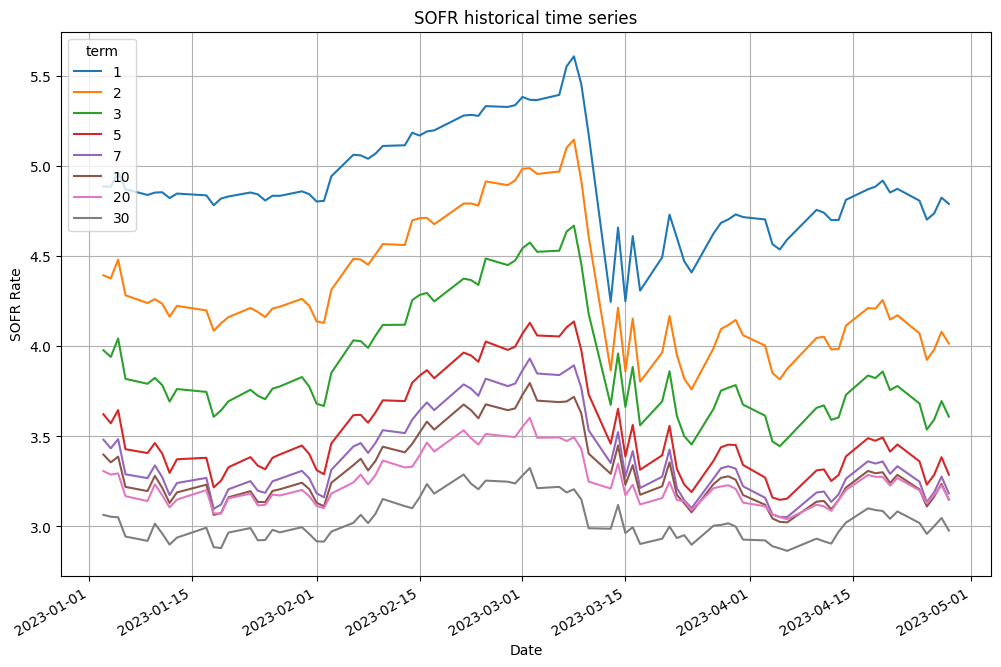

In [58]:
# sofr_symbology_df
sofr_symbology_df = pd.read_excel('../data/sofr_swaps_symbology.xlsx')
sofr_symbology_df.set_index('figi',inplace=True)
print(sofr_symbology_df)

# sofr_market_quotes_df
sofr_market_quotes_df = pd.read_excel('../data/sofr_swaps_market_data_eod.xlsx')
sofr_market_quotes_df.columns = ['date', 'figi', 'mid_rate']
# print(sofr_market_quotes_df.head())

# pivot to get SOFR rates time series
sofr_quotes_ts = sofr_market_quotes_df.pivot(index="date", columns="figi", values="mid_rate")
sofr_quotes_ts.columns = sofr_symbology_df.term[sofr_quotes_ts.columns]
# print(sofr_quotes_ts.head())

plt = sofr_quotes_ts.plot(grid=True, style='-', title='SOFR historical time series', figsize=(12,8))
plt.set_ylabel('SOFR Rate')
plt.set_xlabel('Date')

## b. Calibrate the US SOFR yield curve (via bootstrapping)
The function below shows how to calibrate a smooth yield/discount factor curve from SOFR swaps. 

Prepare a joint symbology & market dataframe quotes as of 2023-04-28. 

Calibrate the SOFR discount factor curve as of 2023-04-28.

Follow section 11b.

In [59]:
def calibrate_sofr_curve_from_frame(
        calc_date: ql.Date,
        sofr_details: pd.DataFrame,
        rate_quote_column: str):
    '''Create a calibrated yield curve from a SOFR details dataframe which includes rate quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = sofr_details.sort_values(by='term')    
    
    # settle_days
    settle_days = 2
    
    # For US SOFR OIS Swaps 
    day_count = ql.Actual360()

    # For US SOFR Swaps     
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    sofr_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        sofr_quote = row[rate_quote_column]
        tenor_in_years = row['term']
        sofr_tenor = ql.Period(tenor_in_years, ql.Years)
        
        # create sofr_rate_helper
        sofr_helper = ql.OISRateHelper(settle_days, sofr_tenor, ql.QuoteHandle(ql.SimpleQuote(sofr_quote/100)), ql.Sofr())
                        
        sofr_helpers.append(sofr_helper)
        
    sofr_yield_curve = ql.PiecewiseLinearZero(settle_days, calendar, sofr_helpers, day_count)
    sofr_yield_curve.enableExtrapolation()
    
    return sofr_yield_curve

In [60]:
# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(28, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

# combined_df
combined_df = sofr_symbology_df.merge(sofr_market_quotes_df[sofr_market_quotes_df['date'] == '2023-04-28'], how='left', on=['figi'])
print(combined_df.head())

# calibrate SOFR discount curve
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date, combined_df, 'mid_rate')
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)


           figi   ticker   class             bbg                     name   
0  BBG00KFWPJJ9  USOSFR1  Curncy  USOSFR1 Curncy  USD OIS  ANN VS SOFR 1Y  \
1  BBG00KFWPJX3  USOSFR2  Curncy  USOSFR2 Curncy  USD OIS  ANN VS SOFR 2Y   
2  BBG00KFWPK15  USOSFR3  Curncy  USOSFR3 Curncy  USD OIS  ANN VS SOFR 3Y   
3  BBG00KFWPK51  USOSFR5  Curncy  USOSFR5 Curncy  USD OIS  ANN VS SOFR 5Y   
4  BBG00KFWPK79  USOSFR7  Curncy  USOSFR7 Curncy  USD OIS  ANN VS SOFR 7Y   

   term  type      dcc exchange country currency status       date  mid_rate  
0     1  SWAP  ACT/360     NONE      US      USD   ACTV 2023-04-28   4.79000  
1     2  SWAP  ACT/360     NONE      US      USD   ACTV 2023-04-28   4.01500  
2     3  SWAP  ACT/360     NONE      US      USD   ACTV 2023-04-28   3.60900  
3     5  SWAP  ACT/360     NONE      US      USD   ACTV 2023-04-28   3.28700  
4     7  SWAP  ACT/360     NONE      US      USD   ACTV 2023-04-28   3.18275  


## c. Display the calibrated SOFR discount curve dataframe

Follow section 11d to display the calibration details dataframe.

In [61]:
def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df

In [62]:
# Display and plot SOFR yield curve
grid_dates = [sofr_yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,2))]


sofr_yield_curve_simple_df = get_yield_curve_details_df(sofr_yield_curve)                  # using calibration grid
sofr_yield_curve_details_df = get_yield_curve_details_df(sofr_yield_curve, grid_dates)    # using external grid

print(sofr_yield_curve_simple_df)
print(sofr_yield_curve_details_df)

         Date  YearFrac  DiscountFactor  ZeroRate
0  2023-05-02     0.000           1.000     4.788
1  2024-05-02     1.017           0.954     4.788
2  2025-05-02     2.031           0.923     3.998
3  2026-05-04     3.050           0.898     3.584
4  2028-05-02     5.075           0.850     3.256
5  2030-05-02     7.103           0.802     3.152
6  2033-05-02    10.147           0.732     3.123
7  2043-05-04    20.297           0.534     3.139
8  2053-05-02    30.439           0.419     2.899
          Date  YearFrac  DiscountFactor  ZeroRate
0   2023-05-02     0.000           1.000     4.788
1   2025-05-02     2.031           0.923     3.998
2   2027-05-02     4.058           0.872     3.420
3   2029-05-02     6.089           0.825     3.204
4   2031-05-02     8.117           0.778     3.142
5   2033-05-02    10.147           0.732     3.123
6   2035-05-02    12.175           0.687     3.126
7   2037-05-02    14.206           0.646     3.129
8   2039-05-02    16.233           0.606 

## d. Plot the calibrated US SOFR Zero Interest Rates and Discount Factor curves

Plot the SOFR zero rates and discount factor curves by maturity. Follow section 11c.

In [63]:
def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df

Text(0.5, 0, 'Date')

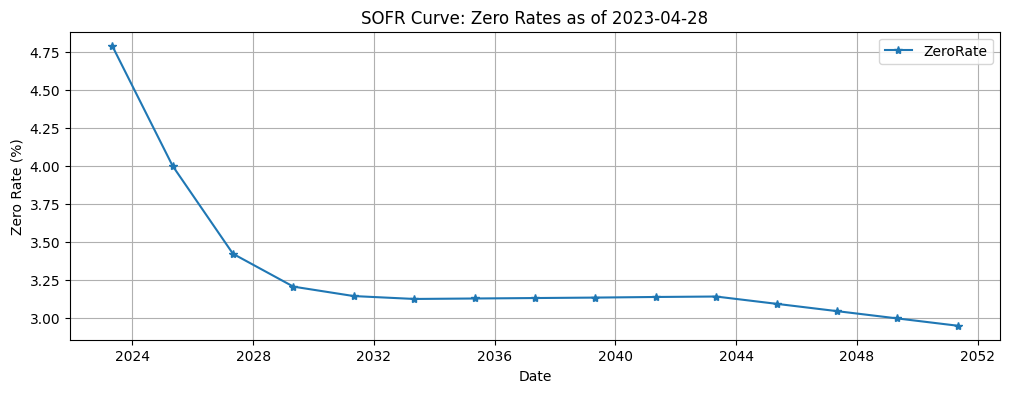

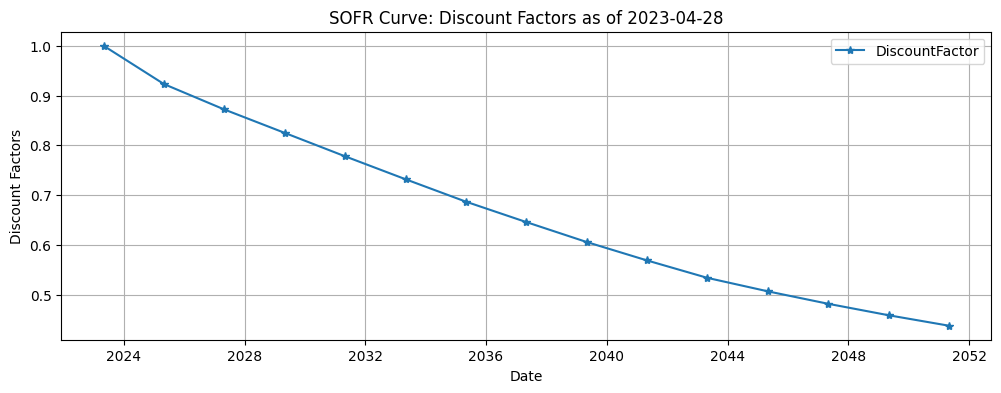

In [64]:
# Plot the SOFR yield curve
plt = sofr_yield_curve_details_df.plot(x='Date', y='ZeroRate', grid=True, style='*-', title='SOFR Curve: Zero Rates as of 2023-04-28', figsize=(12,4))
plt.set_ylabel('Zero Rate (%)')
plt.set_xlabel('Date')

plt = sofr_yield_curve_details_df.plot(x='Date', y='DiscountFactor', grid=True, style='*-', title='SOFR Curve: Discount Factors as of 2023-04-28', figsize=(12,4))
plt.set_ylabel('Discount Factors')
plt.set_xlabel('Date')

# Problem 4: CDS Hazard Rate calibration and valuation
## Follow Section "12. CDS Hazard Rate calibration + Pricing" in the QuantLib Intro notebook !!!

## a. Load and explore the CDS market data (IBM credit issuer)

Load the `cds_market_data_eod` Excel file into a dataframe. 

Plot the historical time series of CDS Par Spreads for the available tenors.


        date ticker                short_name    tier      sector  region   
0 2023-01-03    IBM  Intl Business Machs Corp  SNRFOR  Technology  N.Amer  \
1 2023-01-04    IBM  Intl Business Machs Corp  SNRFOR  Technology  N.Amer   
2 2023-01-05    IBM  Intl Business Machs Corp  SNRFOR  Technology  N.Amer   
3 2023-01-06    IBM  Intl Business Machs Corp  SNRFOR  Technology  N.Amer   
4 2023-01-09    IBM  Intl Business Machs Corp  SNRFOR  Technology  N.Amer   

  currency doc_clause  running_coupon  cds_assumed_recovery  par_spread_1y   
0      USD       XR14            0.01                   0.4       0.001849  \
1      USD       XR14            0.01                   0.4       0.001825   
2      USD       XR14            0.01                   0.4       0.001859   
3      USD       XR14            0.01                   0.4       0.001778   
4      USD       XR14            0.01                   0.4       0.001706   

   par_spread_2y  par_spread_3y  par_spread_5y  par_spread_7y  par_s

Text(0.5, 0, 'Date')

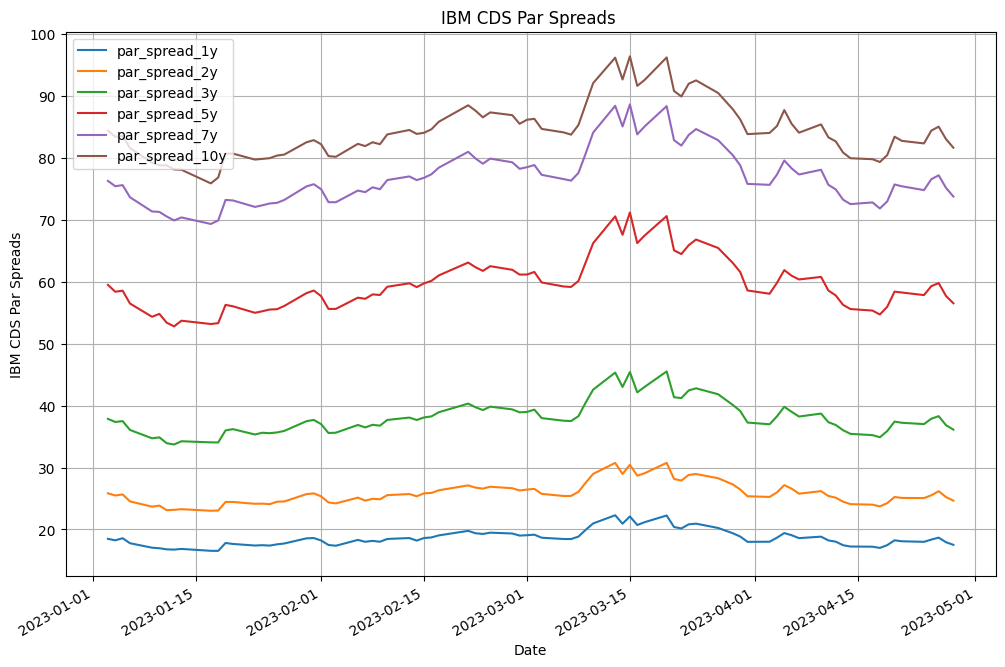

In [65]:
# cds_market_quotes_df
cds_market_quotes_df = pd.read_excel('../data/cds_market_data_eod.xlsx')
print(cds_market_quotes_df.head())

# Create par spreads (bps) dataframe
par_spread_col_names = [f'par_spread_{n}y' for n in [1,2,3,5,7,10]]
cds_par_spreads_df = cds_market_quotes_df.set_index('date')[par_spread_col_names].apply(lambda x: x*1e4)

plt = cds_par_spreads_df.plot(grid=True, style='-', title='IBM CDS Par Spreads ', figsize=(12,8))
plt.set_ylabel('IBM CDS Par Spreads')
plt.set_xlabel('Date')


## b. Calibrate the IBM hazard rate curve as of 2023-04-28

Follow section 12a. Use the calibrated SOFR discount curve from 2b.

In [66]:
def calibrate_cds_hazard_rate_curve(calc_date, sofr_yield_curve_handle, cds_par_spreads_bps, cds_recovery_rate = 0.4):
    '''Calibrate hazard rate curve from CDS Par Spreads'''
    CDS_settle_days = 2

    CDS_day_count = ql.Actual360()

    # CDS standard tenors: 1Y, 2Y, 3Y, 5Y 7Y and 10Y
    CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
              

    CDS_helpers = [ql.SpreadCdsHelper((cds_par_spread / 10000.0), CDS_tenor, CDS_settle_days, ql.TARGET(),
                                  ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, CDS_day_count, cds_recovery_rate, sofr_yield_curve_handle)
               
    for (cds_par_spread, CDS_tenor) in zip(cds_par_spreads_bps, CDS_tenors)]

    # bootstrap hazard_rate_curve
    hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, CDS_day_count)
    hazard_rate_curve.enableExtrapolation()

    return(hazard_rate_curve)


def get_hazard_rates_df(hazard_rate_curve):
    '''Return dataframe with calibrated hazard rates and survival probabilities'''
    
    CDS_day_count = ql.Actual360()
    
    hazard_list = [(hr[0].to_date(), 
                CDS_day_count.yearFraction(calc_date, hr[0]),
                hr[1] * 1e4,
                hazard_rate_curve.survivalProbability(hr[0])) for hr in hazard_rate_curve.nodes()]

    grid_dates, year_frac, hazard_rates, surv_probs = zip(*hazard_list)

    hazard_rates_df = pd.DataFrame(data={'Date': grid_dates, 
                                     'YearFrac': year_frac,
                                     'HazardRateBps': hazard_rates,                                     
                                     'SurvivalProb': surv_probs})
    return(hazard_rates_df)


In [67]:
# CDS spreads for IBM as of calc_date = 2023-04-28
cds_par_spreads = list(cds_par_spreads_df.loc['2023-04-28'])
print(cds_par_spreads)

# cds_recovery_rate
cds_recovery_rate = 0.4

# hazard_rate_curve
hazard_rate_curve = calibrate_cds_hazard_rate_curve(calc_date, sofr_yield_curve_handle, cds_par_spreads, cds_recovery_rate)

# hazard_rates_df
hazard_rates_df = get_hazard_rates_df(hazard_rate_curve)

print(hazard_rates_df)


[17.523300000000003, 24.6527, 36.115, 56.5077, 73.7379, 81.6184]
         Date   YearFrac  HazardRateBps  SurvivalProb
0  2023-04-28   0.000000      28.904702      1.000000
1  2024-06-20   1.163889      28.904702      0.996641
2  2025-06-20   2.177778      55.007775      0.991098
3  2026-06-22   3.197222     103.201283      0.980726
4  2028-06-20   5.222222     152.860002      0.950833
5  2030-06-20   7.250000     208.525893      0.911466
6  2033-06-20  10.294444     174.980221      0.864181


## c. Plot the calibrated Hazard Rates and Survival Probability curves
Follow section 12b. Use the calibrated SOFR discount curve from 2b.

Text(0.5, 0, 'Date')

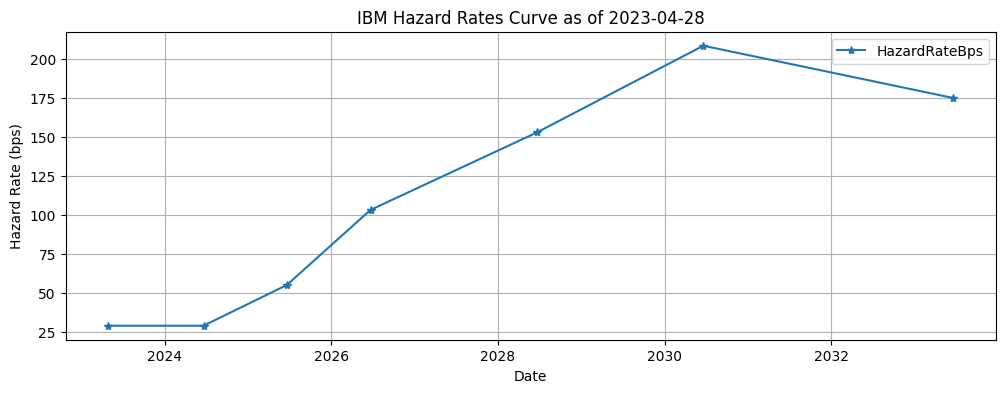

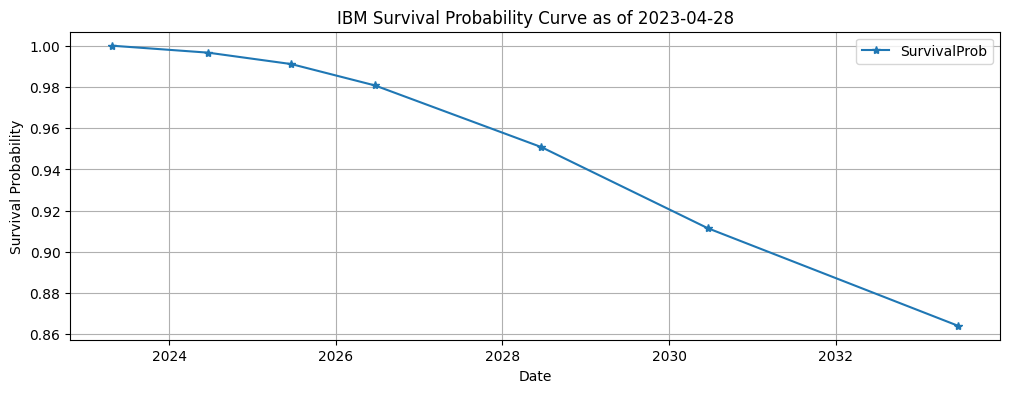

In [68]:
plt = hazard_rates_df.plot(x='Date', y='HazardRateBps', grid=True, style='*-', title='IBM Hazard Rates Curve as of 2023-04-28', figsize=(12,4))
plt.set_ylabel('Hazard Rate (bps)')
plt.set_xlabel('Date')

plt = hazard_rates_df.plot(x='Date', y='SurvivalProb', grid=True, style='*-', title='IBM Survival Probability Curve as of 2023-04-28', figsize=(12,4))
plt.set_ylabel('Survival Probability')
plt.set_xlabel('Date')


## d. Compute the fair/par spread and PV of a CDS 

Follow section 12c. Construct a CDS object with 100 bps coupon and 2027-06-20 maturity. Compute the fair/par spread and PV.




In [69]:
# CDS specs
side = ql.Protection.Seller

face_notional = 100

contractual_spread = 100 / 10000

cds_start_date = ql.Date(28, 4, 2023)
cds_maturity_date = ql.Date(20, 6, 2027)

# Create CDS schedule
cds_schedule = ql.MakeSchedule(cds_start_date, cds_maturity_date, ql.Period('3M'),
                            ql.Quarterly, ql.TARGET(), ql.Following, ql.Unadjusted, ql.DateGeneration.TwentiethIMM)

# Create CDS object
cds_obj = ql.CreditDefaultSwap(side, face_notional, contractual_spread, cds_schedule, ql.Following, ql.Actual360())

# Create CDS pricing engine
default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)
cds_engine = ql.MidPointCdsEngine(default_prob_curve_handle, cds_recovery_rate, sofr_yield_curve_handle)
cds_obj.setPricingEngine(cds_engine)


# Print CDS valuation results
print('CDS protection start date:', cds_obj.protectionStartDate())
print('CDS fair/par spread:', round(cds_obj.fairSpread()*10000, 3))
print('CDS PV:', round(cds_obj.NPV(), 4))    
print('CDS Premium Leg PV:', round(cds_obj.couponLegNPV(), 4))
print('CDS Default Leg PV', round(cds_obj.defaultLegNPV(), 4))
print('Survival Prob. to Maturity:', round(hazard_rate_curve.survivalProbability(cds_maturity_date), 4))


CDS protection start date: April 28th, 2023
CDS fair/par spread: 48.65
CDS PV: 1.968
CDS Premium Leg PV: 3.8325
CDS Default Leg PV -1.8645
Survival Prob. to Maturity: 0.9657
